In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error)

In [8]:
url = 'https://raw.githubusercontent.com/sorif95/ML-Assignment/main/Housing.csv'
df = pd.read_csv(url)
df.isnull().sum()

,0
price,22
area,54
bedrooms,54
bathrooms,54
stories,54
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [9]:
# Handle Missing Values
knn_imputer = KNNImputer(n_neighbors=5)
df['price'].fillna(df['price'].mean(), inplace=True)
df['area'].fillna(df['area'].median(), inplace=True)
df['bedrooms'].fillna(df['bedrooms'].mode()[0], inplace=True)
df['bathrooms'] = knn_imputer.fit_transform(df[['bathrooms']])
df['stories'].fillna(df['stories'].median(), inplace=True)
df['parking'].fillna(df['parking'].mode()[0], inplace=True)

# Encode Categorical Variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Normalize Numeric Features
scaler = StandardScaler()
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# Create Parking Binary Classification Target
df['parking_binary'] = df['parking'].apply(lambda x: 0 if x <= 1 else 1)

<ipython-input-9-789c27d70ba4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['price'].fillna(df['price'].mean(), inplace=True)
<ipython-input-9-789c27d70ba4>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [10]:
# Define Features and Targets
X = df.drop(columns=['price', 'parking_binary'])  # Features
y_classification = df['parking_binary']  # Classification Target
y_regression = df['price']  # Regression Target

# Split Data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)

# Feature Selection Using Random Forest Importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_cls, y_train_cls)

# Select Top Features Based on Importance
feature_importance = pd.Series(rf_classifier.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = feature_importance[:8].index  # Select Top 8 Features

X_train_cls_selected = X_train_cls[top_features]
X_test_cls_selected = X_test_cls[top_features]

# Apply PCA to Reduce Dimensionality
pca = PCA(n_components=5)  # Reduce to 5 Principal Components
X_train_cls_pca = pca.fit_transform(X_train_cls_selected)
X_test_cls_pca = pca.transform(X_test_cls_selected)

# Train SVM Classifier with RBF Kernel and Class Weighting
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42)

# Cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(svm_classifier, X_train_cls_pca, y_train_cls, cv=skf, scoring='f1')
print(f"Cross-Val F1: {np.mean(cross_val_scores):.2f} ± {np.std(cross_val_scores):.2f}")

Cross-Val F1: 0.80 ± 0.07


In [15]:
# Train and Evaluate Classification Model
svm_classifier.fit(X_train_cls_pca, y_train_cls)
y_pred_cls = svm_classifier.predict(X_test_cls_pca)

# Classification Metrics
print("Classification Metrics:")
print(f"Test Accuracy: {accuracy_score(y_test_cls, y_pred_cls):.2f}")
print(f"Precision: {precision_score(y_test_cls, y_pred_cls):.2f}")
print(f"Recall: {recall_score(y_test_cls, y_pred_cls):.2f}")
print(f"F1-score: {f1_score(y_test_cls, y_pred_cls):.2f}")

Classification Metrics:
Test Accuracy: 0.91
Precision: 0.69
Recall: 1.00
F1-score: 0.81


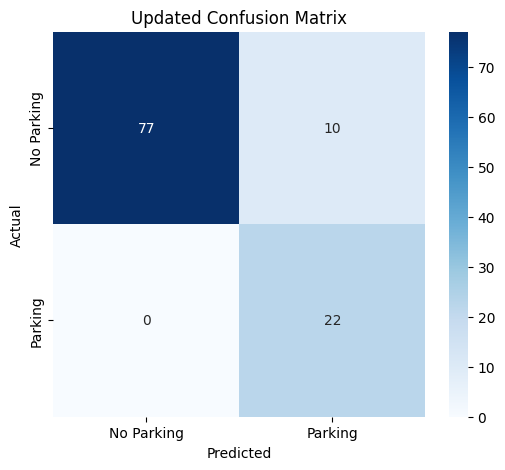

In [12]:
# Confusion Matrix Visualization
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test_cls, y_pred_cls), annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Parking", "Parking"], yticklabels=["No Parking", "Parking"])
plt.title("Updated Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
# Train SVM Regressor (No Changes to Regression)
svm_regressor = SVR(kernel='linear', C=0.1)
svm_regressor.fit(X_train_reg, y_train_reg)
y_pred_reg = svm_regressor.predict(X_test_reg)

# Regression Metrics
mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)

print("\nRegression Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² score: {r2:.2f}")



Regression Metrics:
MSE: 0.47
RMSE: 0.69
MAE: 0.46
R² score: 0.66


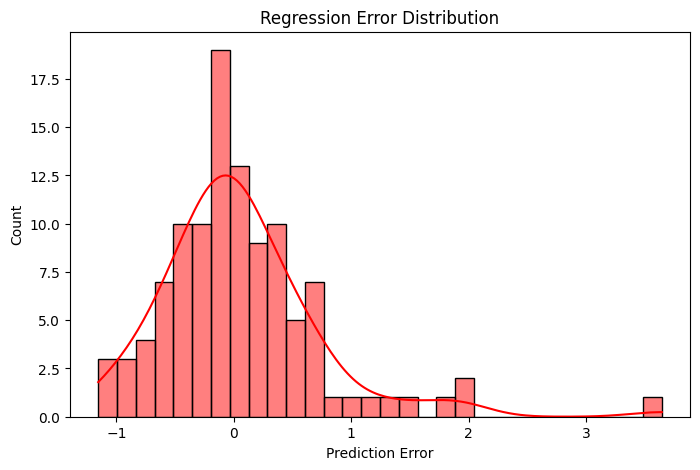

In [14]:
# Regression Error Distribution Visualization
plt.figure(figsize=(8,5))
sns.histplot(y_test_reg - y_pred_reg, bins=30, kde=True, color='red')
plt.title("Regression Error Distribution")
plt.xlabel("Prediction Error")
plt.show()